In [ ]:
import os
!pip install --upgrade kaggle

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/My Drive/Kaggle'  

In [ ]:
%cd  /content/gdrive/My\ Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
%pwd

'/content/gdrive/My Drive/Kaggle'

In [ ]:
!kaggle competitions download -c facial-keypoints-detection

SampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
 56% 9.00M/16.0M [00:00<00:00, 9.28MB/s]
100% 16.0M/16.0M [00:00<00:00, 17.4MB/s]
 82% 49.0M/60.1M [00:02<00:01, 8.56MB/s]
100% 60.1M/60.1M [00:02<00:00, 21.6MB/s]
IdLookupTable.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip \*.zip && rm *.zip

Archive:  test.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                

Archive:  training.zip
replace training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: training.csv            

2 archives were successfully processed.


In [ ]:
!ls

best_FKD_model.hdf5  kaggle.json	   test.csv
IdLookupTable.csv    SampleSubmission.csv  training.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import load_model
from math import pi,cos,sin
import cv2

Using TensorFlow backend.


In [ ]:
 def get_image_and_dots(df, index):
    image = plt.imshow(df['Image'][index],cmap='gray')
    l = []
    for i in range(1,31,2):
        l.append(plt.plot(df.loc[index][i-1], df.loc[index][i], 'rx'))
        
    return image, l

In [ ]:
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
IdLookupTable = pd.read_csv('IdLookupTable.csv')
SampleSubmission = pd.read_csv('SampleSubmission.csv')

In [ ]:
train = train.dropna()
train['Image'] = train['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))

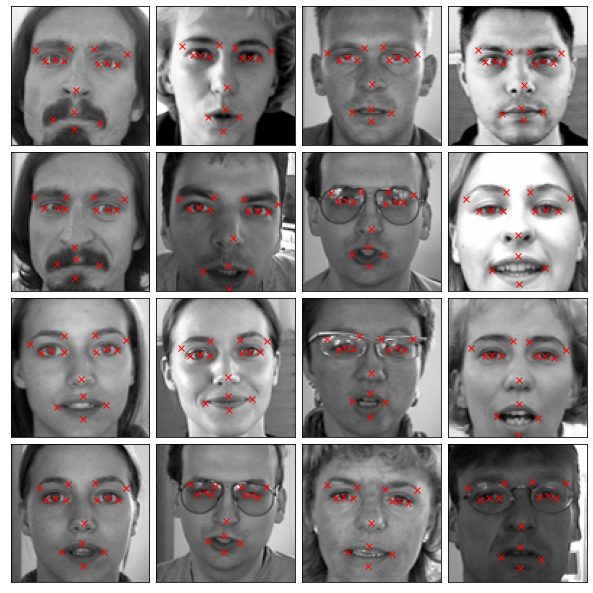

In [ ]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    get_image_and_dots(train, i)

plt.show()

In [ ]:
X = np.asarray([train['Image']], dtype=np.uint8).reshape(train.shape[0],96,96,1)
X = np.array(X)/255
y = train.drop(['Image'], axis=1)
y2 = y.to_numpy()

In [ ]:
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)
    for idx, sample_keypoints in enumerate(keypoints):
        flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])
    return flipped_images, flipped_keypoints

In [ ]:
flipped_X, flipped_y = left_right_flip(X,y2)
X = np.concatenate((X, flipped_X))
y2 = np.concatenate((y2, flipped_y))

In [ ]:
print(X.shape)
print(y2.shape)

(4280, 96, 96, 1)
(4280, 30)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.3, random_state=42)

In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding='same',use_bias=False,input_shape=(96,96,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(96,(3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(96,(3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(128,(3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(256,(3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(512,(3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 32)       

In [ ]:
checkpointer = ModelCheckpoint(filepath='best_FKD_model.hdf5',monitor='val_mae',verbose=1,save_best_only=True,mode='min')
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae','acc'])
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=128,callbacks=[checkpointer])

Train on 2996 samples, validate on 1284 samples
Epoch 1/15
2996/2996 [==============================] - 12s 4ms/step - loss: 590.6002 - mae: 18.3896 - acc: 0.2697 - val_loss: 651.4866 - val_mae: 22.1116 - val_acc: 0.6822

Epoch 00001: val_mae improved from inf to 22.11161, saving model to best_FKD_model.hdf5
Epoch 2/15
2996/2996 [==============================] - 9s 3ms/step - loss: 203.7760 - mae: 10.4750 - acc: 0.4306 - val_loss: 351.5406 - val_mae: 15.6399 - val_acc: 0.6822

Epoch 00002: val_mae improved from 22.11161 to 15.63989, saving model to best_FKD_model.hdf5
Epoch 3/15
2996/2996 [==============================] - 9s 3ms/step - loss: 194.8128 - mae: 10.1322 - acc: 0.4940 - val_loss: 318.3378 - val_mae: 14.8380 - val_acc: 0.6822

Epoch 00003: val_mae improved from 15.63989 to 14.83803, saving model to best_FKD_model.hdf5
Epoch 4/15
2996/2996 [==============================] - 9s 3ms/step - loss: 170.7947 - mae: 9.4852 - acc: 0.5154 - val_loss: 282.1604 - val_mae: 12.5121 - val

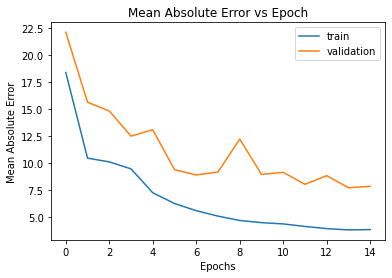

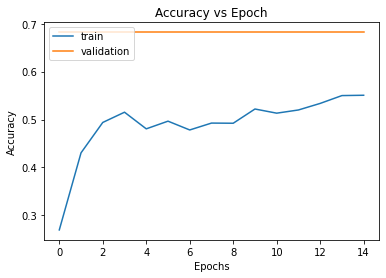

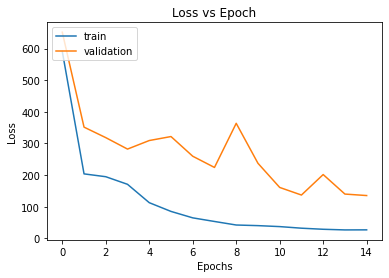

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error vs Epoch')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test['Image'] = test['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))

In [ ]:
test_image = np.asarray([test['Image']], dtype=np.uint8).reshape(test.shape[0],96,96,1)
test_image = np.array(test_image) /255

In [ ]:
model = load_model('best_FKD_model.hdf5')
test_pred = model.predict(test_image)

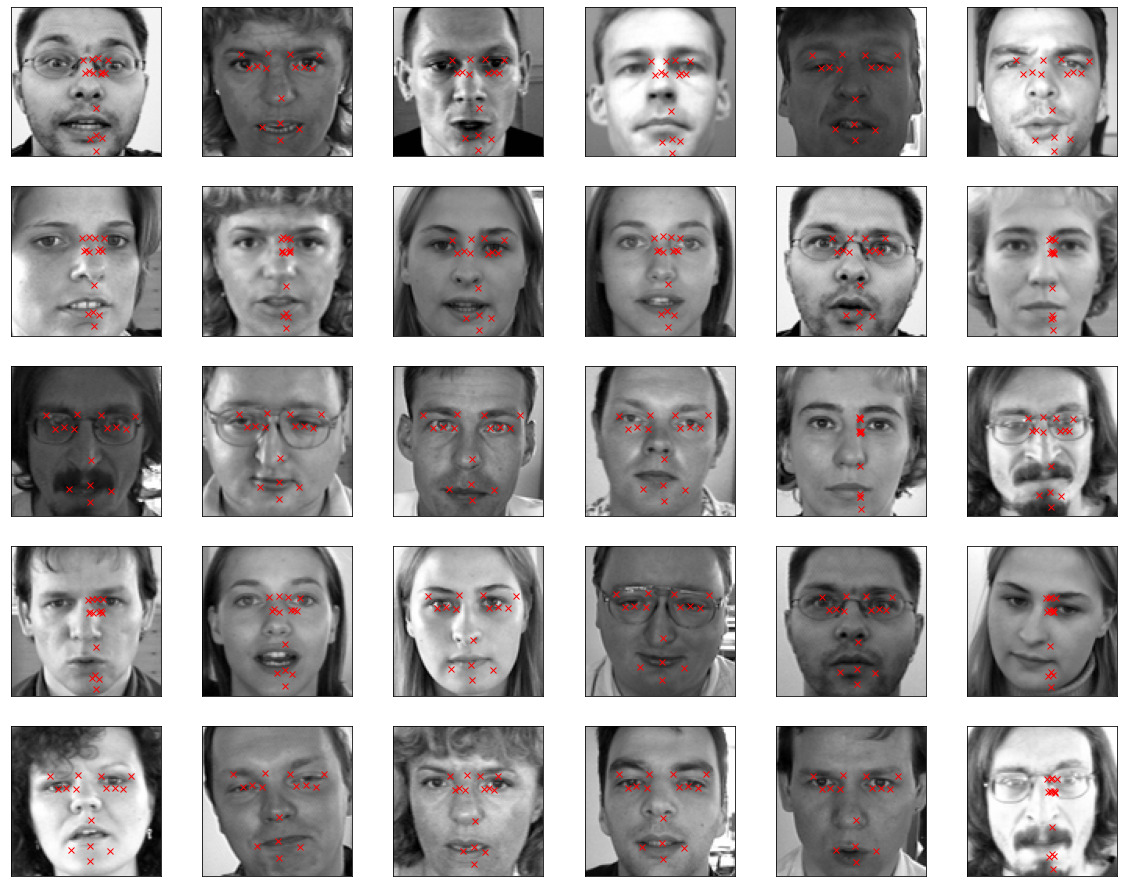

In [ ]:
ffig = plt.figure(figsize=(20,16))
for j in range(30):
  axis = ffig.add_subplot(5,6,j+1,xticks=[],yticks=[])
  axis.imshow(test_image[j].reshape(96,96),cmap='gray')
  for i in range(1,31,2):
    axis.plot(test_pred[j][i-1], test_pred[j][i], 'rx')
plt.show()